In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.high_order_pcf import PCFKernel
from Path_Char.model import LSTMGenerator, UnitaryLSTMGenerator
from Path_Char.utils import AddTime
from torch.utils.data import DataLoader
import ml_collections

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
# Using seaborn's style
plt.style.use('seaborn-colorblind')
width = 345
tex_fonts = {
    "text.usetex": False,  # put False if this raises errors
    "font.family": "serif",
    "axes.labelsize": 24,
    "font.size": 22,
    "legend.fontsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    'figure.figsize': (7, 5),
}
plt.rcParams.update(tex_fonts)
# torch.manual_seed(0)
device = 'cuda'

In [2]:
config = {'G_input_dim': 2,
          'G_hidden_dim': 32,
          'G_num_layers': 2,
          'G_output_dim': 5}
config = ml_collections.ConfigDict(config)

In [3]:
torch.manual_seed(0)
np.random.seed(0)
# number of path coordinates and number of time steps
D, L = 1, 3 

# experimental setup
repeats, n_samples, n, lambda_ = 100, 500, 5*1e5, 1e-5

# to store the sample paths from X_n and X
X = np.zeros((repeats, n_samples, 2, L, D)) 
X_n = np.zeros((repeats, n_samples, 2, L, D))   

# sample from X_n 
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
omega_2 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X_n[:, :, :, 1, 0] = omega_1 * 1./n
X_n[:, :, :, 2, 0] = 0.1 * omega_1

# sample from X
omega_1 = np.random.choice(a=[-1, 1], size=(repeats, n_samples, 2))
X[:, :, :, 2, 0] = 0.1 * omega_1

X = torch.tensor(X.reshape([-1, L, D]))
X_n = torch.tensor(X_n.reshape([-1, L, D]))

X = AddTime(X).to(torch.float)
X_n = AddTime(X_n).to(torch.float)

In [4]:
train_X_dl = DataLoader(X, 512, shuffle=True)
train_X_n_dl = DataLoader(X_n, 512, shuffle=True)

In [5]:
embedding_X = UnitaryLSTMGenerator(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
embedding_X.to(device)

embedding_X_n = UnitaryLSTMGenerator(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
embedding_X_n.to(device)

UnitaryLSTMGenerator(
  (rnn): LSTM(2, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=50, bias=False)
  (activation): Tanh()
)

In [6]:
class expected_dev():
    
    def __init__(self, embedding_X, embedding_X_n, latent_dim, lie_degree_2, add_time = True, device = 'cuda'):
        super(expected_dev, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.device = device
        self.embedding_X = embedding_X
        self.embedding_X_n = embedding_X_n
        self.embedding_X.to(device)
        self.embedding_X_n.to(device)

        
        self.latent_dim = latent_dim
        self.add_time = add_time
        self.num_samples_2 = 10
        self.lie_degree_2 = 5
        self.pcf_level_2 = char_func_path(num_samples=self.num_samples_2, 
                                      hidden_size=self.lie_degree_2, 
                                      input_dim=2*self.latent_dim**2, 
                                      add_time=add_time, 
                                      include_initial = False,
                                      return_sequence=False)
        self.pcf_level_2.to(device)
    
    def train_M(self, X_dl, X_n_dl):
        iterations = 10000
        best_loss = 0.
        embedding_optimizer = torch.optim.Adam(self.embedding_X.parameters(), betas=(0, 0.9), lr=0.002)
        char_2_optimizer = torch.optim.Adam(self.pcf_level_2.parameters(), betas=(0, 0.9), lr=0.002)
        
        print('start opitmize charateristics function')
        self.embedding_X.train()
        self.pcf_level_2.train()
        for i in tqdm(range(iterations)):
            
            X = next(iter(X_dl))
            X_n = next(iter(X_n_dl))
            with torch.no_grad():
                embedded_X = self.embedding_X(X, self.device).reshape([-1, X.shape[1], self.latent_dim**2])
                embedded_Y = self.embedding_X(X_n, self.device).reshape([-1, X.shape[1], self.latent_dim**2])
#                 print(embedded_X.shape, embedded_Y.shape)
                embedded_X = torch.cat([embedded_X.real, embedded_X.imag],-1)
                embedded_Y = torch.cat([embedded_Y.real, embedded_Y.imag],-1)
                
#             print(embedded_X.shape, embedded_Y.shape)
            
            embedding_optimizer.zero_grad()
            char_2_optimizer.zero_grad()
            
            char_loss = - self.pcf_level_2.distance_measure(embedded_X, embedded_Y, Lambda=0)
            
            if -char_loss > best_loss:
                print("Loss updated: {}".format(-char_loss))
                best_loss = -char_loss
            if i%100 == 0:
                print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
            char_loss.backward()
            embedding_optimizer.step()
            char_2_optimizer.step()
    
    def evaluate(self, X_dl, X_n_dl):
        self.pcf_level_2.eval()
        self.embedding_X.eval()
        repeats = 100
        MMD_1 = np.zeros((repeats))
        MMD_2 = np.zeros((repeats))
        with torch.no_grad():
            for i in tqdm(range(repeats)):
                X = next(iter(X_dl))
                X_n = next(iter(X_n_dl))
                X_ = next(iter(X_dl))
                embedded_X = self.embedding_X(X, self.device).reshape([-1, X.shape[1], self.latent_dim**2])
                embedded_Y = self.embedding_X(X_n, self.device).reshape([-1, X.shape[1], self.latent_dim**2])
                embedded_X_ = self.embedding_X(X_, self.device).reshape([-1, X.shape[1], self.latent_dim**2])
                
                embedded_X = torch.cat([embedded_X.real, embedded_X.imag],-1)
                embedded_Y = torch.cat([embedded_Y.real, embedded_Y.imag],-1)
                embedded_X_ = torch.cat([embedded_X_.real, embedded_X_.imag],-1)
                
                MMD_1[i] = self.pcf_level_2.distance_measure(embedded_X, embedded_X_, Lambda=0)
                MMD_2[i] = self.pcf_level_2.distance_measure(embedded_X, embedded_Y, Lambda=0)
        return MMD_1, MMD_2

In [7]:
expected_devx = expected_dev(embedding_X = embedding_X, embedding_X_n = embedding_X_n, latent_dim = config.G_output_dim, lie_degree_2 = 5)

In [8]:
expected_devx.train_M(train_X_dl, train_X_n_dl)

start opitmize charateristics function


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss updated: 5.295060691423714e-05
Iteration 0 :  loss = 5.295060691423714e-05
Loss updated: 8.71064403327182e-05
Loss updated: 0.0001475337048759684
Loss updated: 0.0005220728344283998
Loss updated: 0.0005781779182143509
Loss updated: 0.0009161336347460747
Loss updated: 0.0009553738054819405
Iteration 100 :  loss = 5.673646228387952e-05
Loss updated: 0.0021255461033433676
Loss updated: 0.0025534385349601507
Iteration 200 :  loss = 0.0012920721201226115
Loss updated: 0.004287537187337875
Iteration 300 :  loss = 0.0029195209499448538
Loss updated: 0.004335502628237009
Loss updated: 0.004684880375862122
Loss updated: 0.006352405529469252
Loss updated: 0.008809946477413177
Iteration 400 :  loss = 0.0003496460267342627
Loss updated: 0.010850857011973858
Loss updated: 0.011004154570400715
Iteration 500 :  loss = 6.841588765382767e-05
Loss updated: 0.014840508811175823
Loss updated: 0.017009977251291275
Loss updated: 0.027543125674128532
Iteration 600 :  loss = 9.983354175346904e-06
Iterati

In [9]:
MMD_1, MMD_2 = expected_devx.evaluate(train_X_dl, train_X_n_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

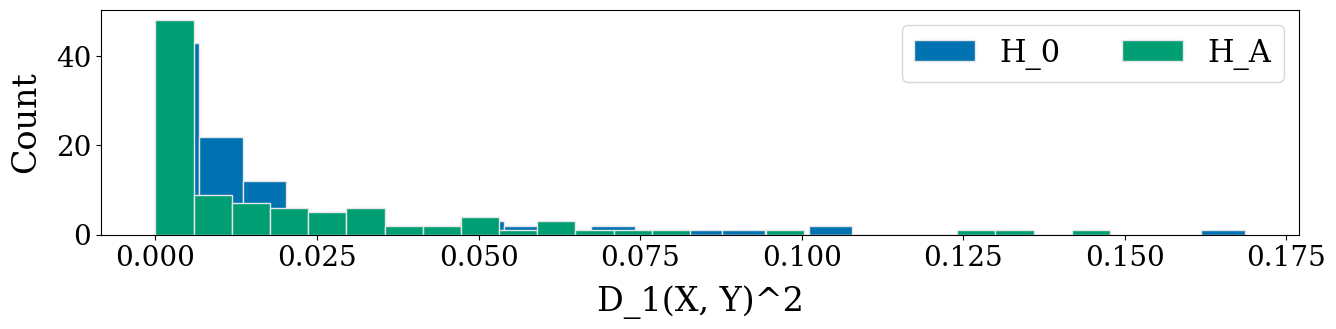

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.hist(MMD_1, bins=25, label='H_0',edgecolor='#E6E6E6')
ax.hist(MMD_2, bins=25, label='H_A',edgecolor='#E6E6E6')

ax.legend(loc='upper right', ncol=2, fontsize=22)
ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
ax.set_ylabel('Count', labelpad=10)

plt.tight_layout(pad=3.0)
# plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
plt.show()